
Name: Rahmani Dibansa

Date: 24th of August 2022

Description:
    This contains my comments on how I understand the data pipeline

Homework:
    Create a function for downres and saturation of image

Reference(s):

    ACMSIGGRAPH. SIGGRAPH Now | Hands-on Workshop: Machine Learning and Neural Networks – Lecture 5

    Retrieved from: https://www.youtube.com/watch?v=PwChjCRkKyU&list=PLUPhVMQuDB_b2kcOooEduedthcBH53mvC&index=5



In [1]:
# Import the necessary packages
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Use the uc_merced dataset provided by tensorflow
# This contains satellite images
import tensorflow_datasets as tfds
merced_builder = tfds.builder('uc_merced')

# Download the dataset
merced_builder.download_and_prepare()

In [3]:
# Display the important information about the dataset
print(merced_builder.info)

tfds.core.DatasetInfo(
    name='uc_merced',
    full_name='uc_merced/2.0.0',
    description="""
    UC Merced is a 21 class land use remote sensing image dataset, with 100 images
    per class. The images were manually extracted from large images from the USGS
    National Map Urban Area Imagery collection for various urban areas around the
    country. The pixel resolution of this public domain imagery is 0.3 m.
    
    While most images are 256x256 pixels, there are 44 images with different shape.
    """,
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    data_path='~/tensorflow_datasets/uc_merced/2.0.0',
    file_format=tfrecord,
    download_size=317.07 MiB,
    dataset_size=238.63 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=21),
    }),
    supervised_keys=('image', 'label'),
    disa

In [4]:
# Display the features of the image
# In this case, the image has a shape of None, None, 3
# It is colored, and is a floating point data
f = merced_builder.info.features['image']
print(f)
PATCH_WIDTH = 128
PATCH_HEIGHT = 128

Image(shape=(None, None, 3), dtype=tf.uint8)


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


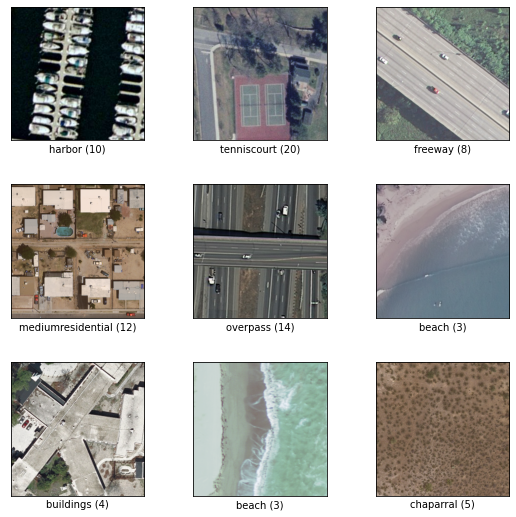

In [5]:
# Use the dataset
datasets = merced_builder.as_dataset()

# take the training data of the dataset
full_ds = datasets['train']

# Display some examples of images from the dataset
fig = tfds.show_examples(merced_builder.info, full_ds)

In [37]:
# add gaussian noise to image
# note: this returns the noisy image as well as the original image
def add_noise(original, std_dev=0.1):
    noise = tf.random.normal(shape=tf.shape(original), mean=0.0, stddev=std_dev, dtype=tf.float32)
    noisy = tf.add(original, noise)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0) # adding noise might make values > 1.0
    # return both the noisy and the normal image
    tensor_tuple = (noisy, original)
    return tensor_tuple


# Additional comments:
#       - The add noise function generates a random noise with the shape similar to
#         the provided images. The intensity of the noise can be adjusted on the std_dev
#       - When adding noise to the original data, its value might exceed 1.
#         To prevent that, we need to clip the value of the noisy image between 0 and 1

In [6]:
# These are the functions that is needed for the homework
# For this homework, I read this documentation: https://www.tensorflow.org/api_docs/python/tf/image


# For downgrading the resolution of the image
# resize the image to small and back to large
def downres(original_image):
  make_smaller = tf.image.resize( original_image, size=[100,100], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  make_larger = tf.image.resize( make_smaller, size=[PATCH_HEIGHT, PATCH_WIDTH], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  downres_result = ( make_larger, original_image )
  return downres_result


# Add more color to the image
def saturate(original_image, multiplier= 1.3):
  saturate_image = tf.image.adjust_saturation(original_image, multiplier)
  saturate_result = (saturate_image, original_image)
  return saturate_result


In [7]:
# extracts patches of given size from the image
def extract_patches(example, patch_width=PATCH_HEIGHT, patch_height=PATCH_HEIGHT):
  img = example['image']
  img = tf.image.convert_image_dtype(img, tf.float32)
  patches = tf.image.extract_patches([img], 
     sizes=[1, patch_height, patch_width, 1], 
     strides=[1, patch_height, patch_width, 1],
     rates=[1, 1, 1, 1],
     padding='SAME')
  img_tensor = tf.reshape(patches, [-1, patch_height, patch_width, 3])
  return tf.data.Dataset.from_tensor_slices(img_tensor)

# Additional comments:
#       - The extract function returns a dataset containing the patches
#         taken from the image

In [ ]:
256*256*3*32 +32

In [8]:
# Get the training and testing data
TRAIN_SIZE = int(2100*0.7)
train_ds = full_ds.take(TRAIN_SIZE)
test_ds = full_ds.skip(TRAIN_SIZE)

In [41]:
# prep dataset for training
# this is done by extracting patches and adding noise
train_ds = train_ds.flat_map(extract_patches)
train_ds = train_ds.map(add_noise)

In [ ]:
# prep dataset for testing
# full-size patches in test data, want to test whole images
test_ds = test_ds.flat_map(lambda x: extract_patches(x, 256, 256))
test_ds = test_ds.map(add_noise)
test_ds = test_ds.batch(1) # one item per batch

In [9]:
# Testing homework function: downres

# prep dataset for training
# this is done by extracting patches and adding noise
train_ds = train_ds.flat_map(extract_patches)
train_ds = train_ds.map(downres)

# prep dataset for testing
# full-size patches in test data, want to test whole images
test_ds = test_ds.flat_map(lambda x: extract_patches(x, 256, 256))
test_ds = test_ds.map(downres)
test_ds = test_ds.batch(1) # one item per batch

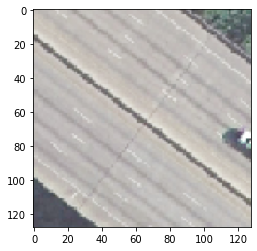

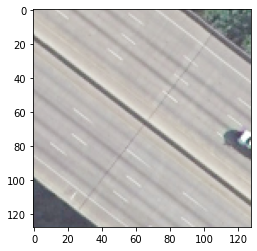

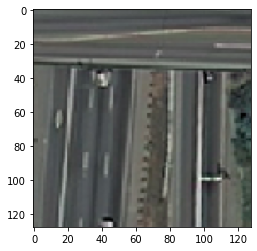

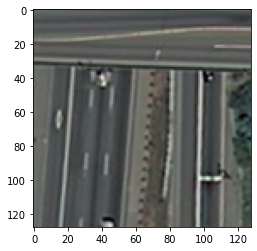

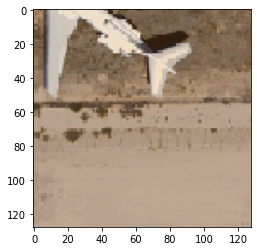

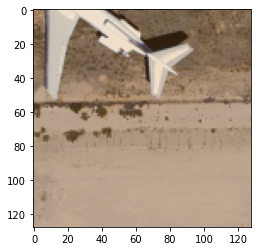

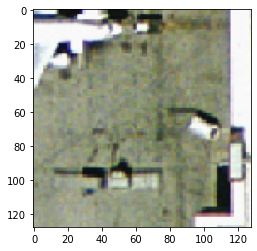

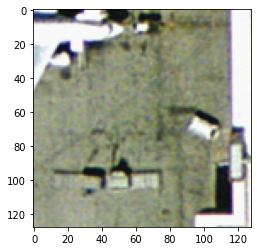

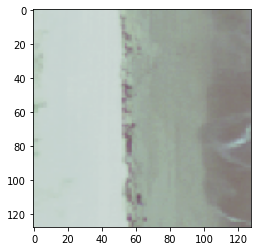

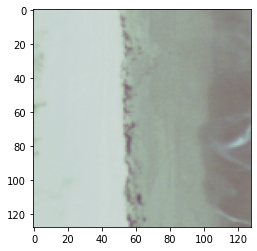

In [10]:
for lowres, orig in train_ds.shuffle(100).take(5): #shuffling before 'take' will give us different images each time
    plt.figure()
    plt.imshow(lowres)
    plt.figure()
    plt.imshow(orig)

In [11]:
# repeat, shuffle and batch
# repeatedly shuffle the data to get produce an lot of data
# and in every batch, take 32 images
train_ds = train_ds.repeat().shuffle(1024).batch(32)

# prefetch to asynchronously fetch batches while the model is training
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)


# Additional comments:
#       - This module contains experimental Dataset sources and transformations 
#         that can be used in conjunction with the tf.data.Dataset API. Note that 
#         the tf.data.experimental API is not subject to the same backwards 
#         compatibility guarantees as tf.data, but we will provide deprecation 
#         advice in advance of removing existing functionality.
#
#       - The tf.data API provides the tf.data.Dataset.prefetch transformation. 
#         It can be used to decouple the time when data is produced from the 
#         time when data is consumed. In particular, the transformation uses a 
#         background thread and an internal buffer to prefetch elements from the 
#         input dataset ahead of the time they are requested. The number of 
#         elements to prefetch should be equal to (or possibly greater than) 
#         the number of batches consumed by a single training step. You could 
#         either manually tune this value, or set it to tf.data.AUTOTUNE, which 
#         will prompt the tf.data runtime to tune the value dynamically at runtime.
#
# Retrieved from: 
#       - https://www.tensorflow.org/api_docs/python/tf/data/experimental
#       - https://www.tensorflow.org/guide/data_performance




In [12]:
# This is a function for creating the convolutional neural network
# It has three layers
def create_modelCNN():
    # build a sequential CNN model
    model = tf.keras.models.Sequential([
        # a stack of Conv2D layers
        # Conv2D( number of nodes, filter size, ...)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(None, None, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same',),
    ])
    return model

In [13]:
# This is the function for the autoencoder
def create_modelAE():
    # build a sequential AutoEncoder model (not used here: just for comparison of number of parameters)
    model = tf.keras.models.Sequential([
        # a stack of Conv2D layers
        tf.keras.layers.Dense(32, activation='relu', input_shape=(None, None, 3)),
        tf.keras.layers.Dense(128*128*3, activation='sigmoid'),
	      tf.keras.layers.Reshape((128, 128, 3))
	  ])
    return model

In [14]:
# Build the CNN model and display its summary
modelCNN = create_modelCNN()
print(modelCNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     1731      
                                                                 
Total params: 21,123
Trainable params: 21,123
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Build the autoencoder model and show the summary
modelAE = create_modelAE()
print(modelAE.summary())

# Additional comments:
#       - As can be seen in the comparison of the number of
#         parameters, we can infer that the CNN is way better
#         than the autoencoder

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, None, 32)    128       
                                                                 
 dense_1 (Dense)             (None, None, None, 49152  1622016   
                             )                                   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
Total params: 1,622,144
Trainable params: 1,622,144
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model = modelCNN
# layers

In [17]:
# compile
model.compile(optimizer='adamax', loss='mae')

In [18]:
# Train the CNN model
train_hist = model.fit(train_ds, epochs=10, steps_per_epoch=10)


# Additional comments:
#         - The steps per epoch simply indicate how many times the batch of the dataset has been fed to the network in each epoch.
# Retrieved from: https://www.codespeedy.com/how-to-set-steps-per-epoch-with-keras/#:~:text=The%20steps%20per%20epoch%20simply,the%20network%20in%20each%20epoch.
                      

Epoch 1/10
10/10 [==============================] - 36s 3s/step - loss: 0.1624
Epoch 2/10
10/10 [==============================] - 33s 3s/step - loss: 0.0773
Epoch 3/10
10/10 [==============================] - 32s 3s/step - loss: 0.0626
Epoch 4/10
10/10 [==============================] - 32s 3s/step - loss: 0.0554
Epoch 5/10
10/10 [==============================] - 33s 3s/step - loss: 0.0481
Epoch 6/10
10/10 [==============================] - 34s 3s/step - loss: 0.0429
Epoch 7/10
10/10 [==============================] - 32s 3s/step - loss: 0.0382
Epoch 8/10
10/10 [==============================] - 32s 3s/step - loss: 0.0345
Epoch 9/10
10/10 [==============================] - 32s 3s/step - loss: 0.0332
Epoch 10/10
10/10 [==============================] - 32s 3s/step - loss: 0.0314


In [19]:
# Take a certain number of prediction batches
# from the test dataset depending on the num predict
NUM_PREDICT=3
prediction_batches = test_ds.take(NUM_PREDICT)

In [28]:
def show_results():
    # plot
    n = NUM_PREDICT  
    plt.figure(figsize=(15, 15))
    for i in range(n):
        # display noisy image
        ax = plt.subplot(4, n, i + 1)
        ax.set_title("Noisy/Downres")
        plt.imshow(noisy_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 + n)
        ax.set_title("Denoised/Reconstructed")
        plt.imshow(denoised_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display ground truth
        ax = plt.subplot(4, n, i + 1 + n + n)
        ax.set_title("Ground Truth")
        plt.imshow(hires_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display the difference (ssim)
        ax = plt.subplot(4, n, i + 1 + n + n + n)
        ax.set_title("Difference")
        plt.imshow(skimage.util.compare_images(hires_imgs[i], denoised_imgs[i], method='diff'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [24]:
hires_imgs = []
noisy_imgs = []
denoised_imgs = []
n=0
for nimg,himg in prediction_batches:
    # predict denoising from the noisy images
    pimg = model.predict(nimg)

    # For the downres homework
    himg = tf.image.resize( himg, size=[128, 128], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    ssim = tf.image.ssim(tf.convert_to_tensor(np.expand_dims(pimg, 0)), himg, 1.0)
    print('SSIM: image:', n, ssim)
    # remove the extra batch dimension for matplotlib
    denoised_imgs.append(tf.squeeze(pimg))
    hires_imgs.append(tf.squeeze(himg))
    noisy_imgs.append(tf.squeeze(nimg))
    n += 1


# Additional comments:
#     - The SSIM tells you how similar the inputted images are
#       Its output will be in the range of 0-1


SSIM: image: 0 tf.Tensor([[0.7464866]], shape=(1, 1), dtype=float32)
SSIM: image: 1 tf.Tensor([[0.8836512]], shape=(1, 1), dtype=float32)
SSIM: image: 2 tf.Tensor([[0.6715112]], shape=(1, 1), dtype=float32)


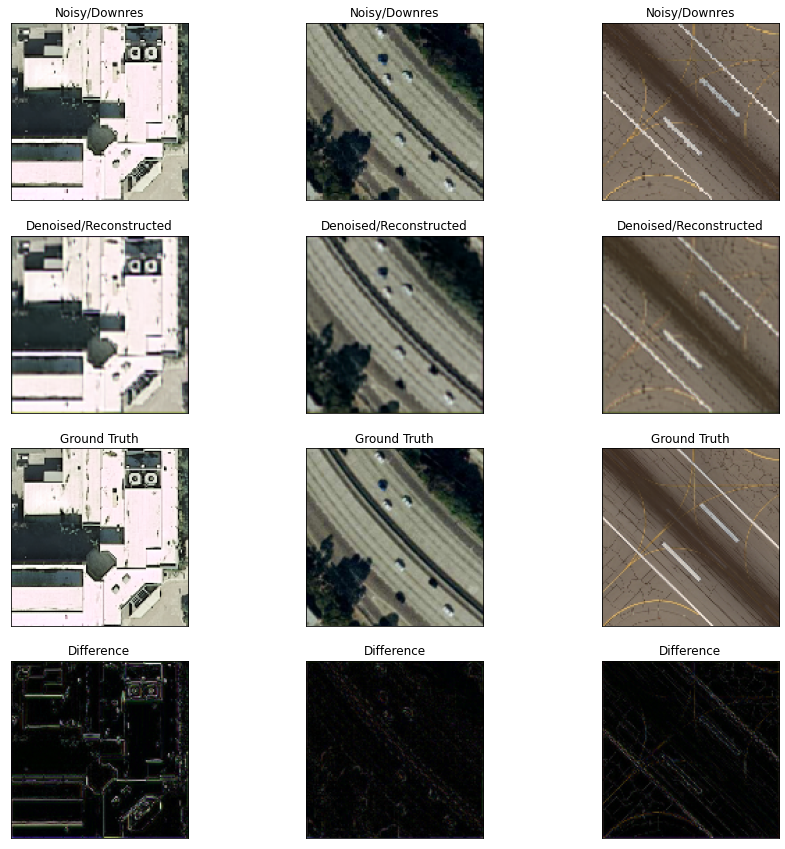

In [29]:
show_results()